# Dataset Introduction
The CIFAR-10 data consists of 60,000 32x32 color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images in the official data. We have preserved the train/test split from the original dataset. The provided files are:

* train.7z - a folder containing the training images in png format
* test.7z - a folder containing the test
* images in png format


trainLabels.csv - the training labels
To discourage certain forms of cheating (such as hand labeling) we have added 290,000 junk images in the test set. These images are ignored in the scoring. We have also made trivial modifications to the official 10,000 test images to prevent looking them up by file hash. These modifications should not appreciably affect the scoring. You should predict labels for all 300,000 images.

######The label classes in the dataset are:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.
Link for Dataset

# Import Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV files (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten
from keras.optimizers import Adam
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical # Corrected import
import time
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import tensorflow as tf

# Turn off warnings for cleaner looking notebook
import warnings
warnings.simplefilter('ignore')

import tensorflow as tf

tf.config.list_physical_devices("GPU")

# Loading the Data


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


In [ ]:
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
x_train[123].min(), x_train[123].max()

(np.uint8(1), np.uint8(243))

# Plotting Sample

(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

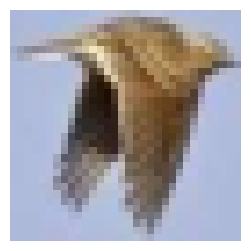

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(x_train[123], cmap='gray')
plt.axis('off')

In [ ]:
classes= ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

In [ ]:
classes[y_train[123][0]]

'bird'

# Exploratory Data Analysis (EDA)
Let's visualize some sample images from the dataset to understand the data better.

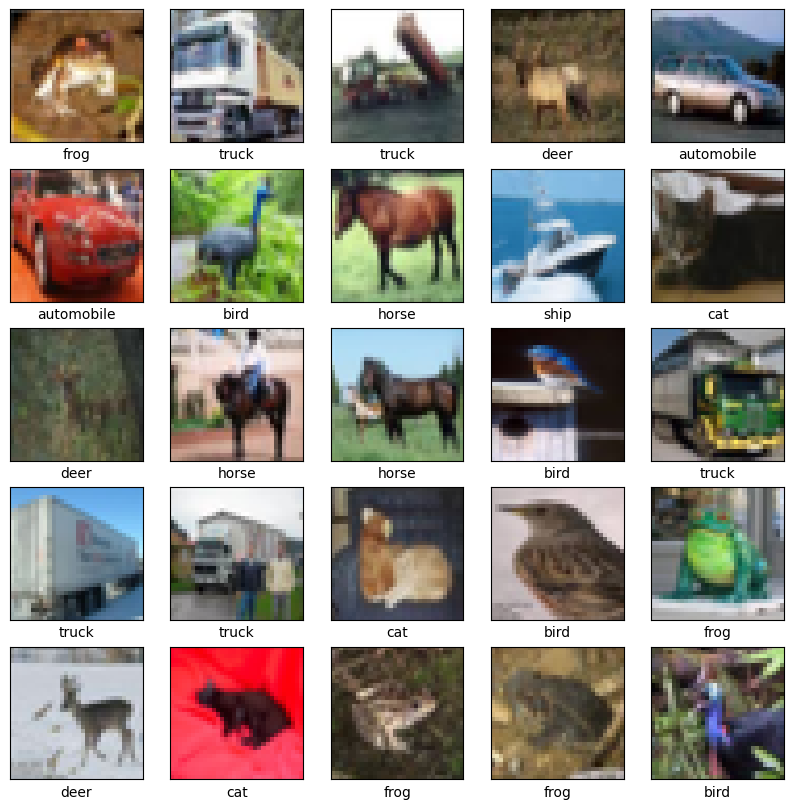

In [ ]:
# Define the class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot a few training images
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    # The CIFAR10 labels are arrays,
    # so you need to add a second dimension
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# Data Preprocessing
Before feeding the data into a neural network, we need to preprocess it. This involves normalizing the pixel values and one-hot encoding the labels.

In [ ]:
# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
x_train[123].min(), x_train[123].max()

(np.float32(0.003921569), np.float32(0.9529412))

# Changing Dtype of Target Feature to Categorical

In [ ]:
# One-hot encode the labels
y_Example = to_categorical(y_train)

y_train_one_hot = to_categorical(y_train, num_classes=10)
y_test_one_hot = to_categorical(y_test, num_classes=10)

np.min(y_Example == y_train_one_hot), y_train_one_hot.shape

print(f"x_train shape after normalization: {x_train.shape}")
print(f"x_test shape after normalization: {x_test.shape}")
print(f"y_train shape after one-hot encoding: {y_train_one_hot.shape}")
print(f"y_test shape after one-hot encoding: {y_test_one_hot.shape}")

x_train shape after normalization: (50000, 32, 32, 3)
x_test shape after normalization: (10000, 32, 32, 3)
y_train shape after one-hot encoding: (50000, 10)
y_test shape after one-hot encoding: (10000, 10)


In [ ]:
y_train_one_hot[123]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

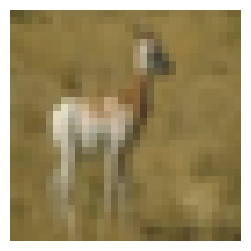

In [ ]:
plt.figure(figsize=(4,3))
plt.imshow(x_train[123], cmap='PuRd_r')
plt.imshow(x_train[58])
plt.axis('off')
plt.show()

# plt.figure(figsize=(4,3))
# plt.imshow(x_train[58])
# plt.axis('off')
# plt.show()

# Build the CNN Model
Now, let's build a Convolutional Neural Network model for image classification. We will use a sequential model with convolutional, pooling, dropout, and dense layers.

In [ ]:
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))

# Flatten the layers
model.add(Flatten())

# Dense Layer 1
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(units=10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Model
Let's train the CNN model using the training data and validate it using the test data. We'll use Early Stopping to prevent overfitting.

In [ ]:
from tqdm import tqdm
# from keras_tqdm import TQDMCallback
from tqdm.keras import TqdmCallback

In [ ]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# Train the model
history = model.fit(x_train, y_train_one_hot, epochs=50, batch_size=32,
                    validation_data=(x_test, y_test_one_hot),
                    callbacks=[early_stopping])

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 53ms/step - accuracy: 0.7525 - loss: 0.6931 - val_accuracy: 0.7131 - val_loss: 0.8635
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 132s 47ms/step - accuracy: 0.7652 - loss: 0.6681 - val_accuracy: 0.7061 - val_loss: 0.9049
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 45ms/step - accuracy: 0.7725 - loss: 0.6417 - val_accuracy: 0.7210 - val_loss: 0.8562
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 81s 45ms/step - accuracy: 0.7741 - loss: 0.6405 - val_accuracy: 0.7108 - val_loss: 0.8877
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 72s 46ms/step - accuracy: 0.7749 - loss: 0.6205 - val_accuracy: 0.7170 - val_loss: 0.8768
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.7868 - loss: 0.5948 - val_accuracy: 0.7113 - val_loss: 0.9431
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.7906 - loss: 0.5837 - val_accuracy: 0.7186 - val_loss: 0.8982
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 73s 46ms/step - accuracy: 0.7968 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 0.8562
Test Accuracy: 0.7210


# Plotting Metrics of the Model

In [ ]:
model.metrics_names

['loss', 'compile_metrics']

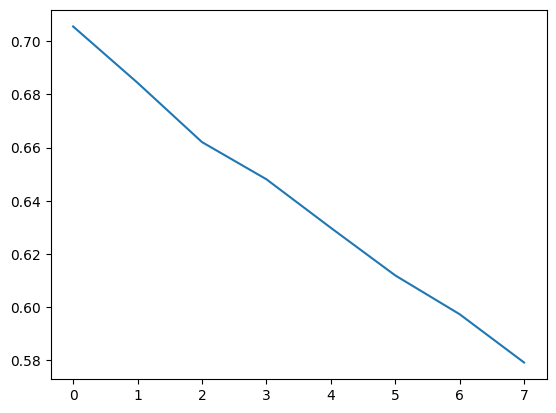

In [ ]:
loss = model.history.history['loss']
plt.plot(loss)
plt.show();

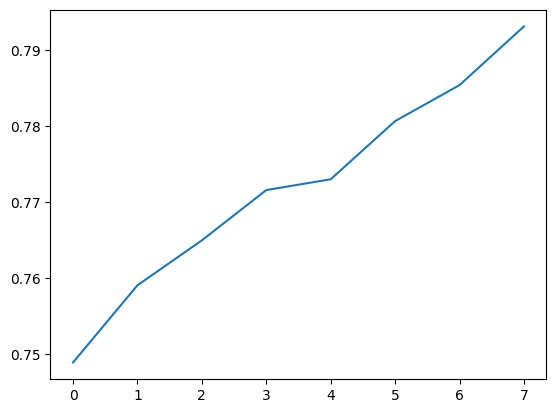

In [ ]:
acc = model.history.history['accuracy']
plt.plot(acc)
plt.show();

In [ ]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

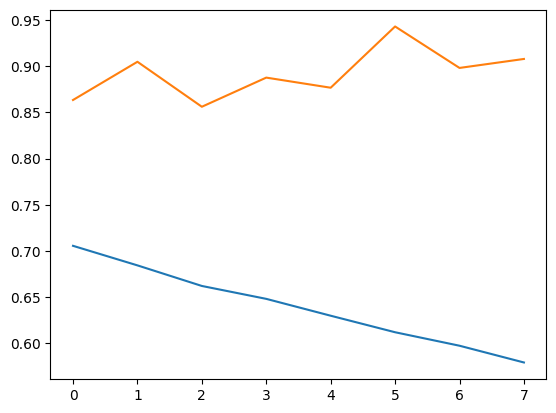

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(loss)
plt.plot(val_loss)
plt.show()

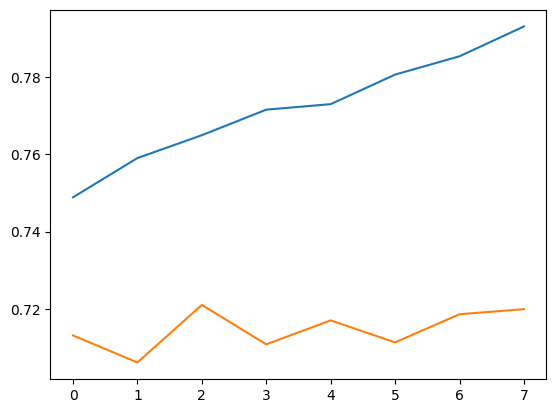

In [ ]:
plt.plot(acc)
plt.plot(val_acc)
plt.show()

# Evaluation of the Model

In [ ]:
ev1 = model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Test Loss: {ev1[0]:.4f}")
print(f"Test Accuracy: {ev1[1]:.4f}")

Test Loss: 0.8562
Test Accuracy: 0.7210


# The Model Predict

In [ ]:
y_preds = model.predict(x_test)
y_preds

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


array([[9.11481271e-04, 5.11850638e-04, 5.16948570e-03, ...,
        3.88017506e-04, 1.84179249e-03, 1.32259724e-04],
       [6.18744865e-02, 3.19976844e-02, 1.67177348e-08, ...,
        5.38981229e-12, 9.04400289e-01, 1.72746961e-03],
       [1.44024640e-01, 6.20808840e-01, 1.78414967e-03, ...,
        7.60835392e-05, 1.64721355e-01, 6.03089631e-02],
       ...,
       [1.91214058e-05, 1.30399201e-06, 2.13127024e-02, ...,
        9.96777043e-03, 9.30445640e-06, 8.41792087e-07],
       [1.14102244e-01, 5.13584178e-04, 3.49504538e-02, ...,
        4.67351318e-04, 1.75705252e-04, 8.59657375e-05],
       [1.27219563e-11, 3.67884027e-15, 7.86287728e-07, ...,
        9.99474227e-01, 1.18111349e-17, 1.20515022e-11]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_preds, axis=1)
y_pred[0]

np.int64(3)

In [ ]:
np.argmax(y_preds, axis=1)

array([3, 8, 1, ..., 5, 4, 7])

In [ ]:
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Report and Heatmap

In [ ]:
print(classification_report(y_test_classes, y_pred, target_names=classes))

              precision    recall  f1-score   support

    airplane       0.73      0.72      0.73      1000
  automobile       0.89      0.83      0.86      1000
        bird       0.61      0.61      0.61      1000
         cat       0.51      0.55      0.53      1000
        deer       0.66      0.70      0.68      1000
         dog       0.61      0.67      0.64      1000
        frog       0.77      0.81      0.79      1000
       horse       0.78      0.74      0.76      1000
        ship       0.91      0.74      0.82      1000
       truck       0.81      0.84      0.83      1000

    accuracy                           0.72     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.72      0.72     10000



Our first model can predict with 73 % accuracy score. The best prediction is about automobiles with 89% and the worst prediction is about cats with 51%.

In [ ]:
confusion_matrix(y_test_classes, y_pred)

array([[723,  15, 109,  41,  17,   5,   4,  14,  34,  38],
       [ 14, 829,   8,  10,   9,   5,  16,   3,  14,  92],
       [ 49,   5, 607,  75,  94,  69,  66,  24,   7,   4],
       [ 18,   5,  57, 551,  70, 200,  61,  29,   2,   7],
       [ 16,   2,  72,  62, 696,  37,  44,  65,   5,   1],
       [  6,   0,  43, 172,  49, 665,  17,  41,   2,   5],
       [  3,   2,  48,  78,  38,  18, 808,   2,   2,   1],
       [  9,   3,  29,  43,  75,  78,   6, 745,   1,  11],
       [121,  24,  17,  29,   6,   5,   9,  10, 745,  34],
       [ 28,  50,  10,  19,   5,   6,  13,  22,   6, 841]])

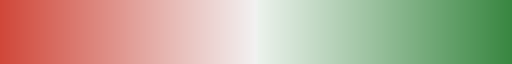

In [ ]:
cmap = sns.diverging_palette(15, 130, as_cmap=True)
cmap

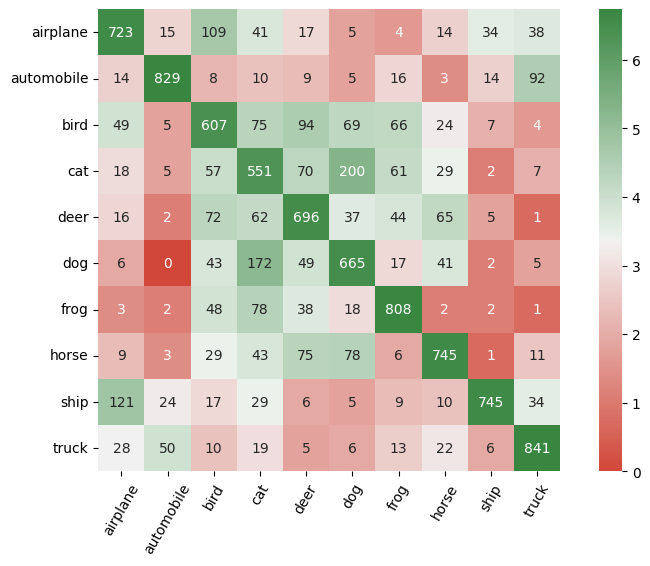

In [ ]:
cm = confusion_matrix(y_test_classes, y_pred)

plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d');

sns.heatmap(np.log1p(cm), annot=cm, cmap=cmap, fmt='d',
            xticklabels=classes, yticklabels=classes, square=True)
plt.xticks(rotation=60)
plt.show()

The results are not that good, improvement is required.

# MODELLING - 2

In [ ]:
model2 = Sequential()

model2.add(Conv2D(64, kernel_size=(4, 4), input_shape=(x_train.shape[1:]), activation='relu', padding='same'))
model2.add(Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'))
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5))

model2.add(Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same'))
model2.add(MaxPool2D((2, 2)))
model2.add(Dropout(0.5))

model2.add(Flatten())

model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(10, activation='softmax'))

model2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-3))
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,530 (1.23 MB)

 Trainable params: 323,530 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
fitData2 = model2.fit(x_train, y_train_one_hot, batch_size=64, epochs=50, validation_data=(x_test, y_test_one_hot),
                      callbacks=[early_stopping], verbose=True)
fitData2

Epoch 1/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 635s 808ms/step - accuracy: 0.2872 - loss: 1.9136 - val_accuracy: 0.4808 - val_loss: 1.4634
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 616s 725ms/step - accuracy: 0.4823 - loss: 1.4282 - val_accuracy: 0.5300 - val_loss: 1.3280
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 622s 725ms/step - accuracy: 0.5433 - loss: 1.2686 - val_accuracy: 0.6063 - val_loss: 1.1288
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 566s 724ms/step - accuracy: 0.5839 - loss: 1.1559 - val_accuracy: 0.6317 - val_loss: 1.0535
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 623s 725ms/step - accuracy: 0.6130 - loss: 1.0784 - val_accuracy: 0.6463 - val_loss: 1.0232
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 630s 735ms/step - accuracy: 0.6347 - loss: 1.0304 - val_accuracy: 0.6688 - val_loss: 0.9565
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 621s 733ms/step - accuracy: 0.6506 - loss: 0.9752 - val_accuracy: 0.6742 - val_loss: 0.9286
Epoch 8/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 614s 723ms/step - accuracy: 0.6689 -

In [ ]:
loss2 = fitData2.history['loss']
val_loss2 = fitData2.history['val_loss']
acc2 = fitData2.history['accuracy']
val_acc2 = fitData2.history['val_accuracy']

plt.plot(loss2)
plt.plot(val_loss2)
plt.show()


In [ ]:
plt.plot(acc2)
plt.plot(val_acc2)
plt.show()

In [ ]:
ev2 = model2.evaluate(X_test, y_test_cat, callbacks=[tfa.callbacks.TQDMProgressBar()])

In [ ]:
y_preds2 = model2.predict(X_test)
y_preds2

In [ ]:
y_pred2 = np.argmax(y_preds2, axis=1)
y_pred2

In [ ]:
y_test_cat2_2 = np.argmax(y_test_cat, axis=1)

In [ ]:
print(classification_report(y_test_cat2_2, y_pred2, target_names=classes))

* n this model our score is 73%, the best predictions are automobile and ship with 84%.

* The results are much better, however we could upgrade it.

In [ ]:
cm2 = confusion_matrix(y_test_cat2_2, y_pred2)

plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d');

sns.heatmap(np.log1p(cm2), annot=cm2, cmap=cmap, fmt='d',xticklabels=classes, yticklabels=classes, square=True)
plt.xticks(rotation=60)
plt.show()

# MODELLING - 3

In [ ]:
from tensorflow.keras.layers import BatchNormalization

In [ ]:
model3 = Sequential()

model3.add(Conv2D(32, kernel_size=(4, 4), input_shape=(X_train.shape[1:]), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2)))

model3.add(Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2)))

model3.add(Conv2D(128, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(256, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2)))

model3.add(Conv2D(256, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(Conv2D(512, kernel_size=(4, 4), activation='relu', padding='same'))
model3.add(BatchNormalization())
model3.add(MaxPool2D((2, 2)))

model3.add(Flatten())

model3.add(Dense(128, activation='relu'))
model3.add(Dense(64, activation='relu'))
model3.add(Dense(10, activation='softmax'))

model3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate = 0.001))
model3.summary()


In [ ]:
fitData3 = model3.fit(X_train, y_train_cat, batch_size=64, epochs=50, validation_data=(X_test, y_test_cat),
                      callbacks=[earlyStoppingCallback, TqdmCallback()], verbose=True)
fitData3

In [ ]:
loss3 = fitData3.history['loss']
val_loss3 = fitData3.history['val_loss']
acc3 = fitData3.history['accuracy']
val_acc3 = fitData3.history['val_accuracy']

plt.plot(loss3)
plt.plot(val_loss3)
plt.show()

In [ ]:
plt.plot(acc3)
plt.plot(val_acc3)
plt.show()

In [ ]:
ev3 = model3.evaluate(X_test, y_test_cat, callbacks=[tfa.callbacks.TQDMProgressBar()])

In [ ]:
y_preds3 = model3.predict(X_test)
y_preds3

In [ ]:
y_pred3 = np.argmax(y_preds3, axis=1)
y_pred3

In [ ]:
y_test_cat2_3 = np.argmax(y_test_cat, axis=1)

In [ ]:
print(classification_report(y_test_cat2_3, y_pred3, target_names=classes))

* As we see above the results are quite good with 83% accuracy score.
* The best prediction is automobile with 93% precision score.
* The worst prediction is cat with 70% score.

In [ ]:
cm3 = confusion_matrix(y_test_cat2_3, y_pred3)

plt.figure(figsize=(10, 6))
# sns.heatmap(cm, annot=True, fmt='d');

sns.heatmap(np.log1p(cm3), annot=cm3, cmap=cmap, fmt='d',xticklabels=classes, yticklabels=classes, square=True)
plt.xticks(rotation=60)
plt.show()


In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
fitData1.history

In [ ]:
loss = fitData1.history['loss']
val_loss = fitData1.history['val_loss']
acc = fitData1.history['accuracy']
val_acc = fitData1.history['val_accuracy']

plt.plot(loss)
plt.plot(val_loss)
plt.show()

In [ ]:
# Get predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded test labels back to class indices
y_test_classes = np.argmax(y_test_one_hot, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test_classes, y_pred_classes), annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Load the saved model
loaded_model = load_model('cifar10_cnn_model.h5')

# Make predictions on a few test images
num_test_images = 5
test_images = x_test[:num_test_images]
true_labels = y_test_classes[:num_test_images]

predictions = loaded_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display the test images with their true and predicted labels
plt.figure(figsize=(12, 4))
for i in range(num_test_images):
    plt.subplot(1, num_test_images, i + 1)
    plt.imshow(test_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_classes[i]]}")
plt.suptitle('Test Images with True and Predicted Labels')
plt.show()

# Finish task

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_one_hot, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

In [ ]:
# Load the saved model
loaded_model = load_model('cifar10_cnn_model.h5')

# Make predictions on a few test images
num_test_images = 5
test_images = x_test[:num_test_images]
true_labels = y_test_classes[:num_test_images]

predictions = loaded_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Display the test images with their true and predicted labels
plt.figure(figsize=(12, 4))
for i in range(num_test_images):
    plt.subplot(1, num_test_images, i + 1)
    plt.imshow(test_images[i])
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_classes[i]]}")
plt.suptitle('Test Images with True and Predicted Labels')
plt.show()

In [ ]:
!pip install tensorflow_addons